## Collection of terrible Graphs.
Graphs are plots of model based dyna implementation, without any annotations bedcause I am lazy.


In [1]:
import jax
import matplotlib.pyplot as plt

from base_rl.higher_order import make_train, CONFIG
from base_rl.models import ActorCritic
from dyna.training import make_dyna_train_fn 
from dyna.global_config import make_hyp_catch
from model_based.transition_models import CatchModel, CatchEquiModel_
from model_based.nn_model import NNCatch
from model_based.sample_env import make_expert_experience_fn, make_experience_fn, SARSDTuple
import model_based.train as mbt
from dyna.types import TransitionModelHyperParams 
import numpy as np
import jax.numpy as jnp
import matplotlib

from gymnax.environments.bsuite.catch import Catch

matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif", "font.size": 16})


# Train Expert  Transition Models:

In [2]:
CONFIG_CATCH = CONFIG
CONFIG_CATCH["ENV"] = Catch()
CONFIG_CATCH["ENV_PARAMS"]=Catch().default_params
rng = jax.random.PRNGKey(42)
expert = jax.jit(make_train(CONFIG_CATCH, ActorCritic) )(rng)
ENV_NAME = "Catch-bsuite"
EXP_TOTAL = 2e5
NUM_PARALLEL = 2000

train_state = expert["runner_state"][0]


128
976.0


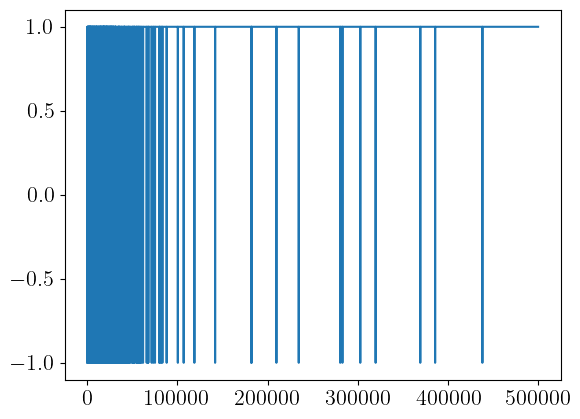

In [3]:
metrics = expert["metrics"]
returns = metrics[0]["returned_episode_returns"].reshape(-1)
plt.plot(returns)

In [4]:

expert_model_params = train_state.params
rng = jax.random.split(rng, NUM_PARALLEL)

random_experienc_fn = make_experience_fn(ENV_NAME, EXP_TOTAL//2 // NUM_PARALLEL)
expert_experience_fn = make_expert_experience_fn(ENV_NAME, EXP_TOTAL//2 //NUM_PARALLEL, expert_model_params)

random_experience = jax.vmap(random_experienc_fn)(rng)
expert_experience = jax.vmap(expert_experience_fn)(rng)

def flatten_shuff(rng, experience: SARSDTuple):
    _len= np.prod(experience.reward.shape)
    flat = jax.tree_map(lambda x: x.reshape(_len, -1), experience)
    perm = jax.random.permutation(rng, _len)
    shuff = jax.tree_map(lambda x: x.at[perm, ...].get(),flat)
    return shuff

rng = jax.random.PRNGKey(42)
expert_experience = flatten_shuff(rng, expert_experience)
random_experience = flatten_shuff(rng, random_experience)
expert_experience = expert_experience.join(random_experience)
expert_experience = jax.tree_map(lambda x: x.astype(jnp.int8), expert_experience)

/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [5]:
NUM_EPCH = 100

def make_model(hyp):
    train_data, val_data = expert_experience.partition(hyp.get_train_size(expert_experience))
    train_fn = jax.jit(mbt.make_train(hyp, train_data, val_data, loss_function_ho=mbt.make_catch_bce_loss_fn, val_loss_function_ho=mbt.make_catch_accuracy_loss_fn))
    out = train_fn(rng)
    losses = out[1]
    train_state = out[0][1]
    return train_state.params, losses

hyp = mbt.HyperParams(model = CatchModel, epochs=NUM_EPCH , )
equi_hyp = mbt.HyperParams(model= CatchEquiModel_ , epochs=NUM_EPCH,)


tm_param, loss = make_model(hyp)
equi_param, equi_loss= make_model(equi_hyp)


# Sense Check model converges.


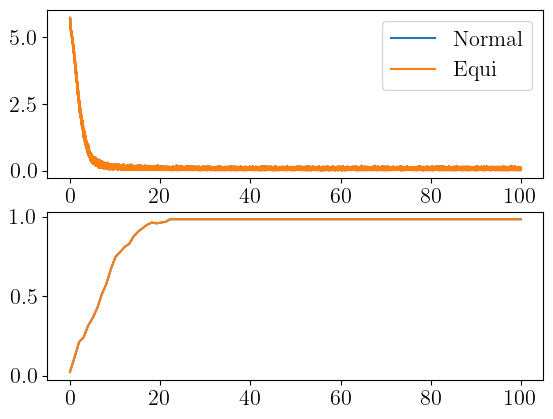

In [6]:

fig, ax = plt.subplots(2,1)
def plot_tm(ax, tm, name):
    train_loss = loss[0].train_loss.reshape(-1)
    val_loss = loss[0].val_loss.reshape(-1)
    def get_x(line, epch):
        return jnp.linspace(0, epch, num = len(line))
    ax[0].plot(get_x(train_loss, NUM_EPCH), (train_loss), label=name)

    ax[1].plot(get_x(val_loss, NUM_EPCH), val_loss)

plot_tm(ax,loss, "Normal")
plot_tm(ax, equi_loss, "Equi")
ax[0].legend()

In [7]:
NUM_SEEDS = 64
NUM_SCANS = 2
dyna_hyp = make_hyp_catch(50)
eqi_hyp = TransitionModelHyperParams(MODEL_FN=CatchEquiModel_, NUM_EPOCHS=0, PARAMS = equi_param)
tm_hyp = TransitionModelHyperParams(MODEL_FN=CatchModel, NUM_EPOCHS=0, PARAMS=tm_param)
no_m_hyp = TransitionModelHyperParams(USE_MODEL=False )
mf_hyp = dyna_hyp._replace(model_hyp=no_m_hyp)
dyna_hyp = dyna_hyp._replace(model_hyp=tm_hyp)
equi_hyp = dyna_hyp._replace(model_hyp=eqi_hyp)

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, NUM_SEEDS)
results= []
hyp = [mf_hyp, dyna_hyp, equi_hyp]
names = ['Model Free', 'Dyna', 'Equi-Dyna']
outer_results = {}
for pr in [1, 2, 4, 8]:
    results = {}
    for h, n in zip(hyp, names):
        h = h._replace(PLANNING_RATIO = pr)
        train_fn = jax.jit(jax.vmap(make_dyna_train_fn(h, NNCatch)))
        rng_split_fn = jax.vmap(jax.random.split)
        def scan_train(rng_state, _ ):
            res = train_fn(rng_state)
            rng_state = rng_split_fn(rng_state)[:, :, -1]
            _, res_info = res
            ret_ep_ret = res_info[1].info["returned_episode_returns"]
            return rng_state, ret_ep_ret

        _, result = jax.lax.scan(
            scan_train,
            rngs,
            None,
            length=NUM_SCANS
        )
        results[n] = result
        del scan_train
        
    outer_results[pr] = results

In [11]:
import pickle
import os
path = "./dyna/expert_catch_new.pkl"
if os.path.isfile(path):
    results_file = open(path, "rb")
    outer_results = pickle.load(results_file)
else:
    results_file = open(path, "wb")
    pickle.dump(outer_results, results_file)


1
Dyna
-0.390625 +- 0.09757809
0.625 +- 0.060515363
0.875 +- 0.060515363
Equi-Dyna
-0.46875 +- 0.08690858
0.71875 +- 0.070067935
0.828125 +- 0.070067935
2
Dyna
-0.46875 +- 0.09598174
0.640625 +- 0.060515363
0.875 +- 0.060515363
Equi-Dyna
-0.484375 +- 0.082679726
0.75 +- 0.056842312
0.890625 +- 0.056842312
4
Dyna
-0.375 +- 0.08888328
0.703125 +- 0.067092046
0.84375 +- 0.067092046
Equi-Dyna
-0.421875 +- 0.08888328
0.703125 +- 0.06391823
0.859375 +- 0.06391823
8
Dyna
-0.359375 +- 0.1158781
0.375 +- 0.08690858
0.71875 +- 0.08690858
Equi-Dyna
-0.296875 +- 0.09258307
0.671875 +- 0.05284277
0.90625 +- 0.05284277


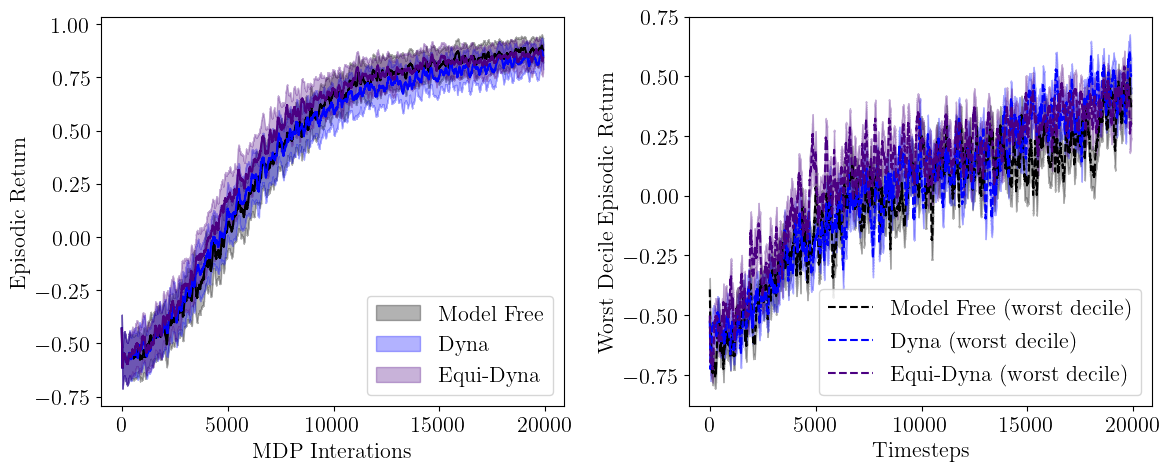

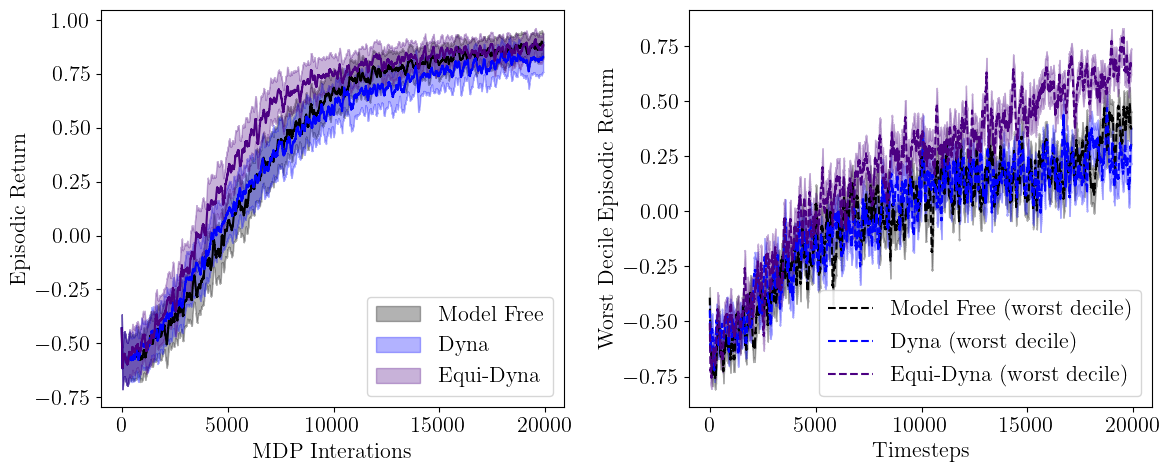

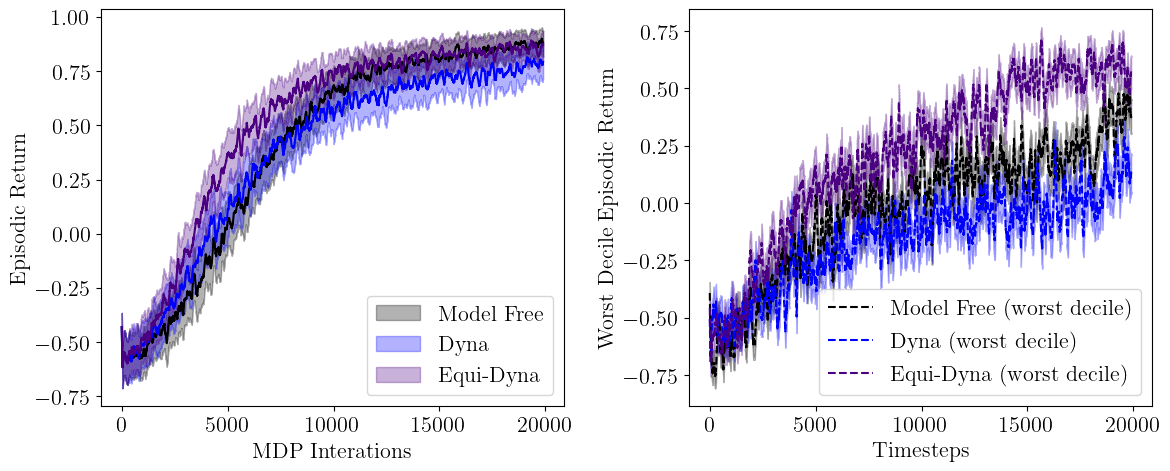

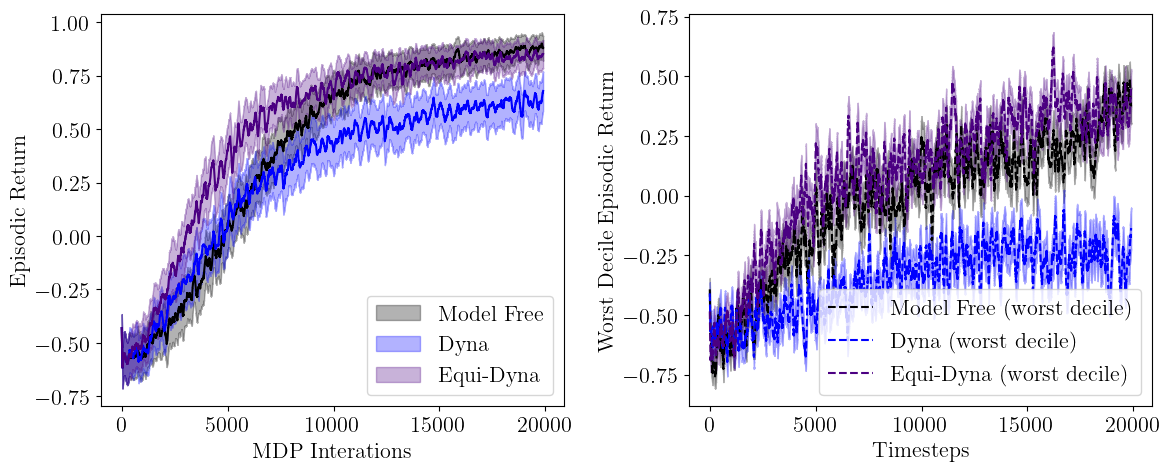

In [13]:
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), "valid") / w

cs = ["black", "blue", "indigo"]
for pr, results in outer_results.items():
    print(pr)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for res, name, c in zip(results.values(), names, cs):
        acting_returns = res
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        ax[0].plot(acting_returns_mean, color=c)
        ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
        ax[0].legend()    
        ax[0].set_xlabel("MDP Interations")
        ax[0].set_ylabel("Episodic Return")
        cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
        worst_decile = np.quantile(cumulative_returns, 0.1)
        worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
        worst_std = acting_returns[cumulative_returns < worst_decile].std(
            axis=0
        ) / np.sqrt(NUM_SEEDS * NUM_SCANS)
        worst_upper = worst_mean + worst_std
        worst_lower = worst_mean - worst_std
        ax[1].plot(
            x,
            moving_average(worst_mean),
            label=f"{name} (worst decile)",
            linestyle="--",
            color=c,
        )
        ax[1].fill_between(
            x,
            moving_average(worst_lower),
            moving_average(worst_upper),
            alpha=0.3,
            color=c,
        )
        ax[1].set_xlabel("Timesteps")
        ax[1].set_ylabel("Worst Decile Episodic Return")
        if name != "Model Free":
            print(name)
            print(acting_returns.mean(axis=0)[2_000],"+-", acting_returns.std(axis=0)[10_000]/np.sqrt(NUM_SEEDS))
            print(acting_returns.mean(axis=0)[10_000],"+-", acting_returns.std(axis=0)[100_000]/np.sqrt(NUM_SEEDS))
            print(acting_returns.mean(axis=0)[-1],"+-", acting_returns.std(axis=0)[-1]/np.sqrt(NUM_SEEDS))


    ax[0].legend()
    ax[1].legend()
    fig.savefig(f"../msc_thesis/Figures/Expert_Dyna_Catch_pr{pr}.png")
    fig.tight_layout()



Dyna
-0.46875 +- 0.09598174
0.640625 +- 0.060515363
0.875 +- 0.060515363


/tmp/ipykernel_29102/3520125687.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Equi-Dyna
-0.296875 +- 0.09258307
0.671875 +- 0.05284277
0.90625 +- 0.05284277


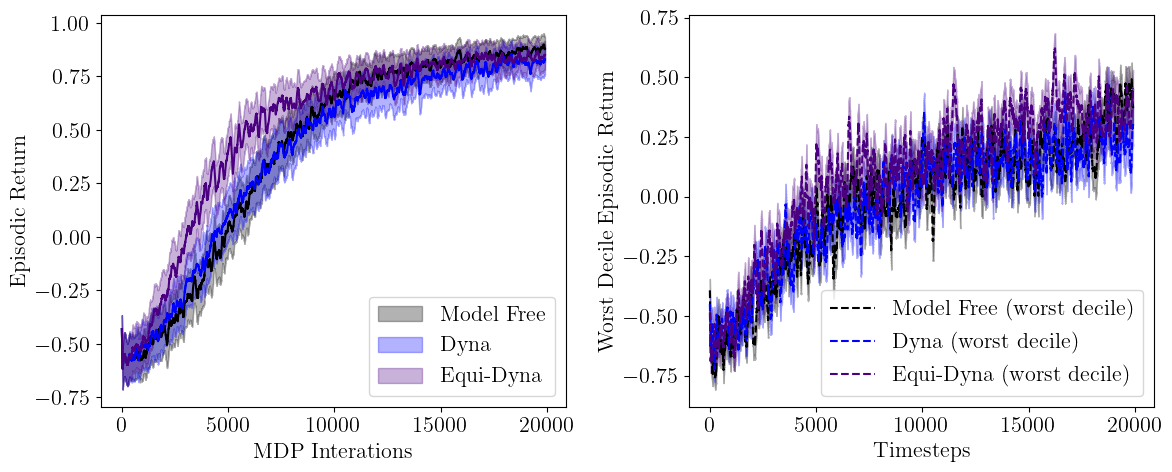

In [14]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for pr, results in outer_results.items():
    for res, name, c in zip(results.values(), names, cs):
        if (pr == 8 and name == "Equi-Dyna") or (pr == 2 and name == "Dyna") or (pr == 1 and name == "Model Free"):
            acting_returns = res
            acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
            acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
            acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
            acting_returns_mean = moving_average(acting_returns_mean)
            acting_returns_std = moving_average(acting_returns_std)
            lower = acting_returns_mean - acting_returns_std
            upper = acting_returns_mean + acting_returns_std
            x = jnp.arange(len(acting_returns_mean))
            ax[0].plot(acting_returns_mean, color=c)
            ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
            ax[0].legend()    
            ax[0].set_xlabel("MDP Interations")
            ax[0].set_ylabel("Episodic Return")
            cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
            worst_decile = np.quantile(cumulative_returns, 0.1)
            worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
            worst_std = acting_returns[cumulative_returns < worst_decile].std(
                axis=0
            ) / np.sqrt(NUM_SEEDS * NUM_SCANS)
            worst_upper = worst_mean + worst_std
            worst_lower = worst_mean - worst_std
            ax[1].plot(
                x,
                moving_average(worst_mean),
                label=f"{name} (worst decile)",
                linestyle="--",
                color=c,
            )
            ax[1].fill_between(
                x,
                moving_average(worst_lower),
                moving_average(worst_upper),
                alpha=0.3,
                color=c,
            )
            ax[1].set_xlabel("Timesteps")
            ax[1].set_ylabel("Worst Decile Episodic Return")
            if name != "Model Free":
                print(name)
                print(acting_returns.mean(axis=0)[2_000],"+-", acting_returns.std(axis=0)[10_000]/np.sqrt(NUM_SEEDS))
                print(acting_returns.mean(axis=0)[10_000],"+-", acting_returns.std(axis=0)[100_000]/np.sqrt(NUM_SEEDS))
                print(acting_returns.mean(axis=0)[-1],"+-", acting_returns.std(axis=0)[-1]/np.sqrt(NUM_SEEDS))


    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    fig.savefig("../msc_thesis/Figures/Expert_dyna_catch_best.png")

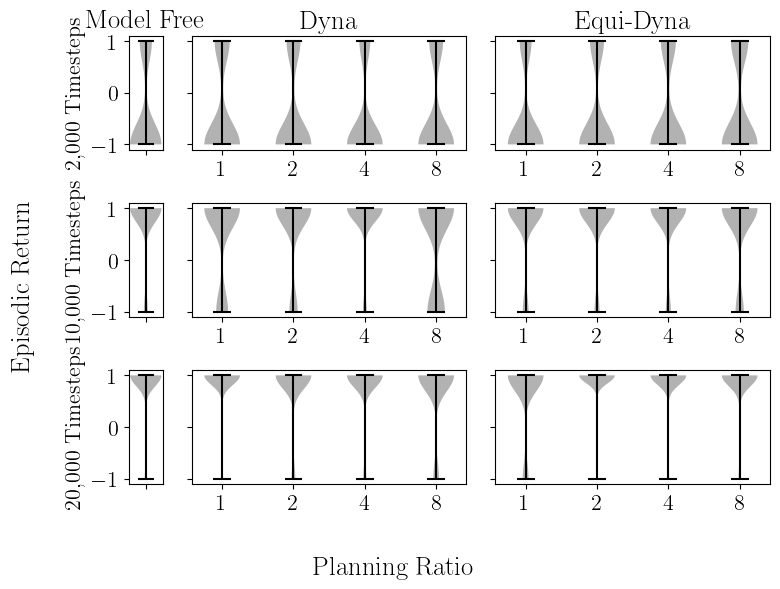

In [16]:
results_dict = {"first": {}, "second": {}, "last": {}}
for pr, results in outer_results.items():
    for res, name, c in zip(results.values(), names, cs):
        acting_returns = res.squeeze().reshape(NUM_SEEDS, -1)

        first = acting_returns[:, 2_000]
        second = acting_returns[:, 10_000]
        last = acting_returns[:, -1]
        results_dict["first"][(name, pr)] = first
        results_dict["second"][(name, pr)] = second
        results_dict["last"][(name, pr)] = last
fig, ax = plt.subplots(3,3, figsize=(8, 6), sharey=True, width_ratios=[1, 8, 8])
mappings = {"first": "2,000", "second": "10,000", "last": "20,000"}
for i, step in enumerate(results_dict):
    values = {name : [results_dict[step][(name, pr)] for pr in outer_results] for name in names}
    for j, (name, c) in enumerate(zip(names, cs)):
        if name == "Model Free":
            vp = ax[i, j].violinplot(values[name][0], widths=[0.2])
            ax[i,j].set_xticks([1], [None])
        else: 
            vp =ax[i, j].violinplot(values[name], )
            ax[i, j].set_xticks([1, 2,3, 4], [1, 2, 4, 8])
            ax[i, j].set_yticks([-1,0,1],)
        ax[0, j].set_title(name)
        for part in vp["bodies"]:
            part.set_facecolor("black")
        for partname in ('cbars','cmins','cmaxes',):
            vp[partname].set_color("black")


    ax[i, 0].set_ylabel(mappings[step] + " Timesteps")
fig.supylabel("Episodic Return")
fig.supxlabel("Planning Ratio")
fig.tight_layout()
fig.savefig("../msc_thesis/Figures/violin_catch_expert.png")

0.5825
0.608125


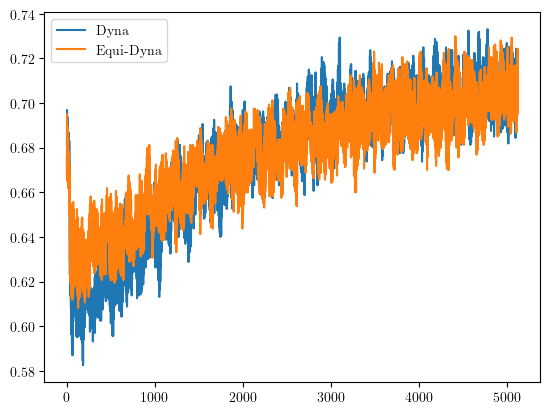

In [ ]:
for info, name in zip(results[1:], names[1:]):
    m_loss= info[-1]
    plt.plot(m_loss.mean(axis=(0, 1)).reshape(-1),  label=name)
    print(jnp.min(m_loss.mean(axis=(0, 1)).reshape(-1)))
    
plt.legend()